# CZ gate coherent error benchmarking

In [1]:
import sys
sys.path.append('/Users/tport/miniconda3/envs/basic_scientific/lib/python3.13/site-packages')

import numpy as np

In [2]:
import numpy as np

folder = "Deterministic benchmarking result - modified"
n_cz = np.load(f"{folder}/num_cz_gates.npy");
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy");
pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

In [3]:
data = pop_00 + pop_01 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_00 + pop_10 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_00 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_01 + pop_10 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_01 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))
data = pop_10 + pop_11 - pop_qb1;
print(np.max(data), np.min(data))

0.9539999831467867 -0.7219999991357327
0.9539999831467867 -0.5209999829530716
0.9329999833134934 -0.6100000068545341
0.6199999861419201 -0.4829999804496765
0.7179999947547913 -0.6710000075399876
2.9802322387695312e-08 -2.9802322387695312e-08


The result of i-th experiment (entire circuit, with preparation and unpreparation) as stored as follows:

* `pop_00[i, t]` = P(00 measurement after evolving till t in i-th experiment)
* `pop_01[i, t]` = P(01 measurement after evolving till t in i-th experiment)
* `pop_10[i, t]` = P(10 measurement after evolving till t in i-th experiment)
* `pop_11[i, t]` = P(11 measurement after evolving till t in i-th experiment)
* `pop_qb1[i, t]` = P(1* measurement after evolving till t in i-th experiment)
* `pop_qb2[i, t]` = P(*1 measurement after evolving till t in i-th experiment)

In [4]:
class Exp():
    NO_DD_00 = 0
    NO_DD_11 = 1
    DD_PP = 2
    DD_P0 = 3
    DD_0P = 4
    PP = 5

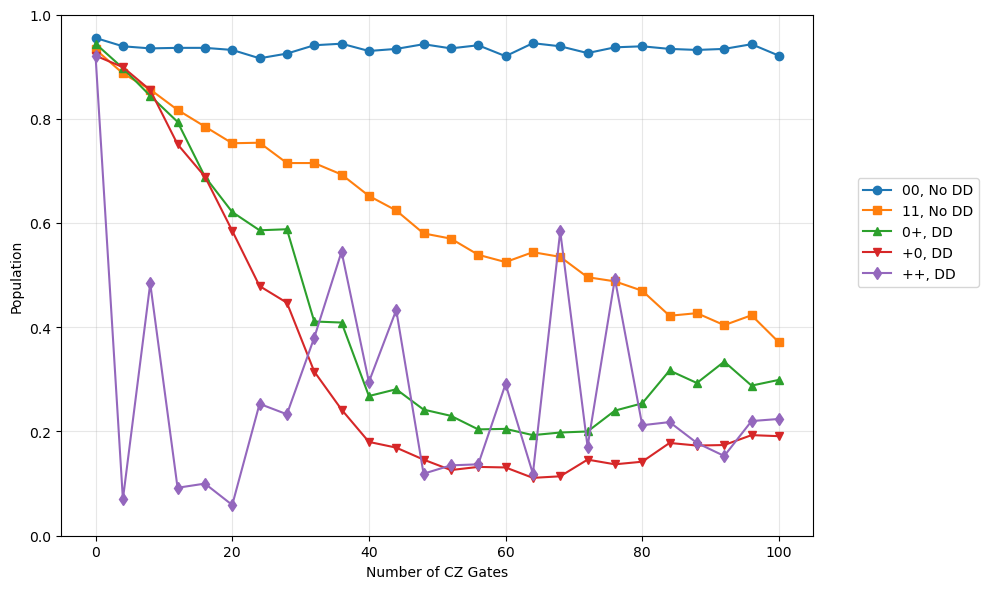

In [5]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.NO_DD_00,:], marker='o', label='00, No DD')
plt.plot(n_cz, pop_00[Exp.NO_DD_11,:], marker='s', label='11, No DD')
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='^', label='0+, DD')
plt.plot(n_cz, pop_00[Exp.DD_P0,:], marker='v', label='+0, DD')
plt.plot(n_cz, pop_00[Exp.DD_PP,:], marker='d', label='++, DD')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

Copy the formulas for fidelities based on open system modelling

In [90]:
from typing import Optional
from dataclasses import dataclass

@dataclass
class DeviceCharacteristics:
    """Device characteristics for the ideal curve.

    None values represent values to be optimized.
    """

    T1_1: float | tuple[float, float] | None
    T1_2: float | tuple[float, float] | None
    T2_1: float | tuple[float, float] | None
    T2_2: float | tuple[float, float] | None
    ZZ: float | tuple[float, float] | None
    ZI: float | tuple[float, float] | None
    IZ: float | tuple[float, float] | None
    infinite_time_spam: float | tuple[float, float] | None
    zero_time_spam: float | tuple[float, float] | None

    def __init__(self, device_dict: dict) -> None:
        for k, v in device_dict.items():
            self.__dict__[k] = v
    
    def get_not_none_keys(self) -> list[str]:
        """Get the values that are not None."""
        return [k for k, v in self.__dict__.items() if v is not None]
    
    def get_bounds_on_unknown_params(self) -> list[str]:
        """Get the values that are lists or tuples."""
        return [v for v in self.__dict__.values() if type(v) in [list, tuple]]

    def get_fixed_value_sub_dict(self) -> dict[str, float]:
        """Get the sub-dictionary with values that are not None."""
        return {k: v for k, v in self.__dict__.items() if v is not None and type(v) not in [list, tuple]}
    
    def get_optimizee_keys(self) -> list[str]:
        """Get the keys which represent parameters subject to optimization."""
        return [k for k, v in self.__dict__.items() if v is not None and type(v) in [list, tuple]]
    
    def update_dict(self, new_dict) -> None:
        self.__dict__.update(new_dict)
    
    def get_dict(self) -> dict[str, float | None]:
        return self.__dict__

In [7]:
T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 4; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

def ideal_curve_for_11(n, evolution_time, device_characteristics: DeviceCharacteristics):
    decay_factor = np.exp(-evolution_time/device_characteristics.T1_1);
    decay_factor = decay_factor * np.exp(-evolution_time/device_characteristics.T1_2);
    decay_factor = decay_factor ** (4 * n)
    return decay_factor;

def ideal_curve_for_0P(n, evolution_time, device_characteristics: DeviceCharacteristics):
    decay_factor = (np.exp(-evolution_time/device_characteristics.T2_2)) ** (4 * n);
    return 0.5 * (1 + np.cos(8 * (device_characteristics.ZZ + device_characteristics.IZ) * n) * decay_factor);

def ideal_curve_for_P0(n, evolution_time, device_characteristics: DeviceCharacteristics):
    decay_factor = (np.exp(-evolution_time/device_characteristics.T2_1)) ** (4 * n);
    return 0.5 * (1 + np.cos(8 * (device_characteristics.ZZ + device_characteristics.ZI) * n) * decay_factor);

def ideal_curve_for_PP(n, evolution_time, device_characteristics: DeviceCharacteristics):
    d1 = (np.exp(-evolution_time/device_characteristics.T2_1)) ** (4);
    d2 = (np.exp(-evolution_time/device_characteristics.T2_2)) ** (4);
    r1 = (np.exp(-evolution_time/device_characteristics.T1_1)) ** (4);
    r2 = (np.exp(-evolution_time/device_characteristics.T1_2)) ** (4);
    
    eps = device_characteristics.ZI;
    kap = device_characteristics.IZ;
    eta = device_characteristics.ZZ;
    
    return 1/16 * (4 + 
        2 * (d1 ** n) * np.cos(8 * (eps + eta) * n) + 
        2 * (d2 ** n) * np.cos(8 * (kap + eta) * n) + 
        2 * (d1 ** n) * (d2 ** n) * np.cos(8 * (eps - kap) * n) + 
        2 * (d1 ** n) * (d2 ** n) * np.cos(8 * (eps + kap) * n) +
        2 * (d2 ** n) * (r1 ** n) * np.cos(8 * (eta - kap) * n) +
        2 * (d1 ** n) * (r2 ** n) * np.cos(8 * (eta - eps) * n) + 
        2 * np.real((-1 + r1) * (d2 ** n) * (np.exp(8j * (eta + kap) * n) *  - np.exp(-8j * (eta - kap) * n) * (r1 ** n)) / (np.exp(4j * eta) + r1)) +
        2 * np.real((-1 + r2) * (d1 ** n) * (np.exp(8j * (eta + eps) * n) *  - np.exp(-8j * (eta - eps) * n) * (r2 ** n)) / (np.exp(4j * eta) + r2))
        )

Design optimization functions

In [8]:
def spam_curve_for_11(
    n : np.ndarray,
    device_characteristics : DeviceCharacteristics):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D)
    ideal_fidelity = ideal_curve_for_11(n, 1, device_characteristics);
    return device_characteristics.infinite_time_spam + device_characteristics.zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def spam_curve_for_0P(
    n : np.ndarray,
    device_characteristics : DeviceCharacteristics):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D) * Cos(8 * n * theta))/2
    ideal_fidelity = ideal_curve_for_0P(n, 1, device_characteristics);
    return device_characteristics.infinite_time_spam + device_characteristics.zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def spam_curve_for_P0(
    n : np.ndarray,
    device_characteristics : DeviceCharacteristics):
    # spam variables lie between 0 and 1
    # (A + B * e^(-4 * n * t / T_D) * Cos(8 * n * theta))/2
    ideal_fidelity = ideal_curve_for_P0(n, 1, device_characteristics);
    return device_characteristics.infinite_time_spam + device_characteristics.zero_time_spam * (ideal_fidelity - 0.5) / 0.5;

def spam_curve_for_PP(
    n : np.ndarray,
    device_characteristics : DeviceCharacteristics):
    # spam variables lie between 0 and 1
    # ideal zero_time_spam = 1/16, infinite_time_spam = 4/16
    ideal_fidelity = ideal_curve_for_PP(n, 1, device_characteristics);
    return device_characteristics.infinite_time_spam + device_characteristics.zero_time_spam * (ideal_fidelity - 4 / 16) * 16;

In [12]:
#### Function wrapper
import numpy as np
from typing import Callable, Literal

ExpType = Literal["00", "01", "10", "11", "0+", "+0", "++"]

def _update_in_position(kwargs: dict[str, float | None], params: tuple[float, ...]) -> dict[str, float]:
    """Update the kwargs in the order of the params.
    
    This works because python stores dicts in insertion order.
    """
    counter = 0
    for k,v in kwargs.items():
        if v is None:
            try:
                kwargs[k] = params[counter]
                counter = counter + 1
            except IndexError as e:
                raise ValueError(f"Not enough parameters provided") from e

    # check if all parameters were used
    if len(params) > counter:
        raise ValueError(f"Too many parameters: {params}")

    # check if all parameters are set in the kwargs
    for k,v in kwargs.items():
        if v is None:
            raise ValueError(f"Missing parameter: {k}")

    return kwargs

def _get_func(func_type: ExpType) -> Callable[..., float]:
    # do some special casing if required
    match func_type:
        case "11":
            return spam_curve_for_11
        case "0+":
            return spam_curve_for_0P
        case "+0":
            return spam_curve_for_P0
        case "++":
            return spam_curve_for_PP
    raise ValueError(f"Unsupported function type: {func_type}")

class OptimizableFunction:
    """Generic class for holding an optimizable function.

    Could've been implemented just using methods too instead of a class.
    But holding known values across calls seems like a useful thing in my mind + can 
    manage state if required.

    Entrypoint is __call__
    """
    def __init__(self, func_type: ExpType, device_characteristics: DeviceCharacteristics):
        self._func_type = func_type
        self._func = _get_func(func_type)
        self._known_param_dict = device_characteristics.get_fixed_value_sub_dict()
        self._dict_keys = device_characteristics.get_not_none_keys();

    def _initialize_dictionary(self) -> dict[str, float | None]:
        return {param: None for param in self._dict_keys}

    def _prepare_dictionary(self, params: tuple[float, ...]) -> dict[str, float]:
        """Prepare kwargs for the function call.
        
        A bit conflicted on the implementation because this substitutes visible 
        complexity for invisble (but slightly less verbose/complex) complexity. Can
        discuss more on getting feedback.
        """
        kwargs = self._initialize_dictionary();
        # update with known values first
        kwargs.update(self._known_param_dict)
        # then update the remainder with scipy provided positional arguments
        return _update_in_position(kwargs, params)

    def __call__(self, x, *params: float) -> float:
        """Caller.
        
        `params` are the guesses for the unknown params."""
        kwargs = self._prepare_dictionary(params)
        new_device_characteristics = DeviceCharacteristics(kwargs);
        return self._func(x, new_device_characteristics)

In [42]:
from parameter_optimization import fit_parameters_scipy_minimize
from parameter_optimization import fit_parameters_curve_fit
from parameter_optimization import fit_parameters_global_optimization
from parameter_optimization import fit_parameters_least_squares

def find_best_fit(
    func_type: ExpType, 
    x: np.ndarray, 
    y: np.ndarray, 
    device_characteristics: DeviceCharacteristics, 
    initial_guess: np.ndarray,
    opt: Literal["global", "minimize", "curve", "least_squares"] = "global"
    ):
    """Find the best fit for the given function type.

    func_type takes in the type of the function to optimize. It could've take in the callable
        directly too. Not sure what was the intended use case.

    known_values: DeviceCharacteristics where non-null values represent fixed values.
    initial_guess: initial guess for the parameters to optimize. Not sure if this was needed
        to be passed or could've been inferred from the function.
    """
    optimizable_func = OptimizableFunction(func_type, device_characteristics)
    bounds = device_characteristics.get_bounds_on_unknown_params();
    match opt:
        case "global":
            optim_params, objective_value, result = fit_parameters_global_optimization(
                optimizable_func, 
                x, y,
                bounds=bounds
            )
        case "minimize":
            optim_params, objective_value, result = fit_parameters_scipy_minimize(
                optimizable_func, 
                x, y,
                initial_guess,
                bounds=bounds
            )
        case "curve":
            optim_params, objective_value, result = fit_parameters_curve_fit(
                optimizable_func, 
                x, y,
                initial_guess,
                bounds=bounds
            )
        case "least_squares":
            optim_params, objective_value, result = fit_parameters_least_squares(
                optimizable_func, 
                x, y,
                initial_guess,
                bounds=bounds
            )
    return optim_params, objective_value, result, optimizable_func

    

In [38]:
angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000);
spam_bound = (0, 1);
device = DeviceCharacteristics({
    "T1_1": -np.inf, "T1_2": -np.inf, "T2_1": -np.inf, "IZ": angle_bound,"T2_2": timescale_bound,
    "ZZ": -np.pi/4, "ZI": -np.pi/4, 
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});

In [43]:
from parameter_optimization import calculate_rmse

for _ in range(10):
    o, y, result, func = find_best_fit("0+", n_cz, pop_00[Exp.DD_0P, :], device, None)
    print(o, calculate_rmse(func(n_cz, *o), pop_00[Exp.DD_0P, :]))

[5.45827132e-03 2.32094900e+02 3.78722509e-01 5.71835576e-01] 0.029518363783098127
[5.45708592e-03 2.31871492e+02 3.78628405e-01 5.71123813e-01] 0.02951635863817615
[5.46830180e-03 2.36517222e+02 3.80452886e-01 5.67018972e-01] 0.029525080780832606
[-5.45740069e-03  2.31980315e+02  3.78638034e-01  5.71377199e-01] 0.029516487201095558
[5.46283297e-03 2.34213392e+02 3.79560788e-01 5.68987448e-01] 0.02951608843918112
[5.45965886e-03 2.32931405e+02 3.78958851e-01 5.70999675e-01] 0.02951701750141491
[-5.46062614e-03  2.33299558e+02  3.79196291e-01  5.69848221e-01] 0.029515033525912695
[-5.45876417e-03  2.32249320e+02  3.78960972e-01  5.70342904e-01] 0.029516567096611584
[5.45254287e-03 2.30096926e+02 3.77926403e-01 5.72525015e-01] 0.029523295537584336
[5.45603314e-03 2.31649605e+02 3.78470514e-01 5.71345801e-01] 0.02951696371413414


Define fitting functions which display the same behavior as the open system model but have free parameters

Check the behavior of the different fitting routines to see which one performs the best. Check the fidelity with |0+⟩ first.

In [46]:
angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000);
spam_bound = (0, 1);

device = DeviceCharacteristics({
    "T1_1": -np.inf, "T1_2": -np.inf, "T2_1": -np.inf, "T2_2": timescale_bound,
    "ZZ": -np.pi/4, "ZI": -np.pi/4, "IZ": angle_bound,
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});
initial_guess = (230, -0.1, 1, 1);

optim_params_global, y, result, func = find_best_fit("0+", n_cz, pop_00[Exp.DD_0P, :], device, initial_guess, opt = "global")
optim_y = func(n_cz, *optim_params_global);
print("\nError from `global`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_global[0])
print("Overrotation", optim_params_global[1])

optim_params_minimize, y, result, func = find_best_fit("0+", n_cz, pop_00[Exp.DD_0P, :], device, initial_guess, opt = "minimize")
optim_y = func(n_cz, *optim_params_minimize);
print("\nError from `minimize`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_minimize[0])
print("Overrotation", optim_params_minimize[1])

optim_params_curve, y, result, func = find_best_fit("0+", n_cz, pop_00[Exp.DD_0P, :], device, initial_guess, opt = "curve")
optim_y = func(n_cz, *optim_params_curve);
print("\nError from `curve`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_curve[0])
print("Overrotation", optim_params_curve[1])

optim_params_squares, y, result, func = find_best_fit("0+", n_cz, pop_00[Exp.DD_0P, :], device, initial_guess, opt = "least_squares")
optim_y = func(n_cz, *optim_params_squares);
print("\nError from `least_squares`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2))
print("Timescale", optim_params_squares[0])
print("Overrotation", optim_params_squares[1])


Error from `global`: 0.022651437481412618
Timescale 234.0481295331394
Overrotation 0.005462044005198294

Error from `minimize`: 1.4641225114528136
Timescale 229.99885961804216
Overrotation -0.1

Error from `curve`: 1.2734253744969322
Timescale 10.000000000000002
Overrotation -0.09999999999999999

Error from `least_squares`: 1.2734253744969322
Timescale 10.000000000000002
Overrotation -0.09999999999999999


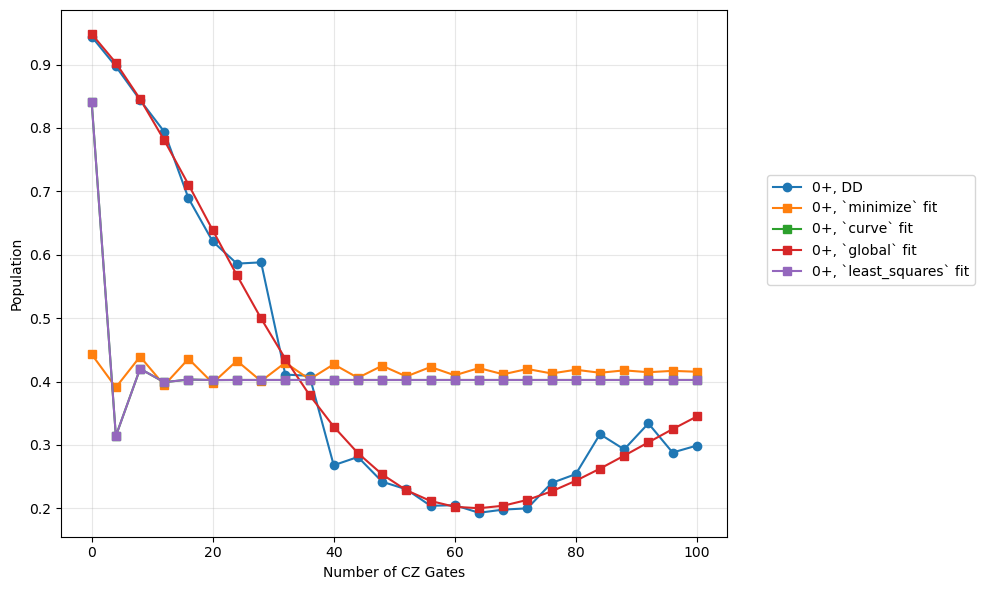

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='o', label='0+, DD')
plt.plot(n_cz, func(n_cz, *optim_params_minimize), marker='s', label='0+, `minimize` fit')
if optim_params_curve is not None:
    plt.plot(n_cz, func(n_cz, *optim_params_curve), marker='s', label='0+, `curve` fit')
plt.plot(n_cz, func(n_cz, *optim_params_global), marker='s', label='0+, `global` fit')
plt.plot(n_cz, func(n_cz, *optim_params_squares), marker='s', label='0+, `least_squares` fit')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()


`least_squares` and `minimize` both are horrendous. But `minimize` changes a lot depending on the initial guess.

Error with initial T_D = 100, rotation = -0.1: 1.4520424115843897
Params: (np.float64(99.99657681527215), np.float64(-0.1))

Error with initial T_D = 100, rotation = 0: 0.09308753068204743
Params: (np.float64(99.99853263126373), np.float64(0.003917296028733766))

Error with initial T_D = 100, rotation = 0.1: 1.4520424115898736
Params: (np.float64(99.99657683729194), np.float64(0.1))

Error with initial T_D = 200, rotation = -0.1: 1.4630137548838427
Params: (np.float64(199.9980774422247), np.float64(-0.1))

Error with initial T_D = 200, rotation = 0: 0.02453489439856897
Params: (np.float64(199.9991431306938), np.float64(-0.005355803339660348))

Error with initial T_D = 200, rotation = 0.1: 1.4630137548860644
Params: (np.float64(199.99807749355946), np.float64(0.1))

Error with initial T_D = 300, rotation = -0.1: 1.4656326739829197
Params: (np.float64(299.9992463266315), np.float64(-0.1))

Error with initial T_D = 300, rotation = 0: 0.026663476170602787
Params: (np.float64(299.9992789989

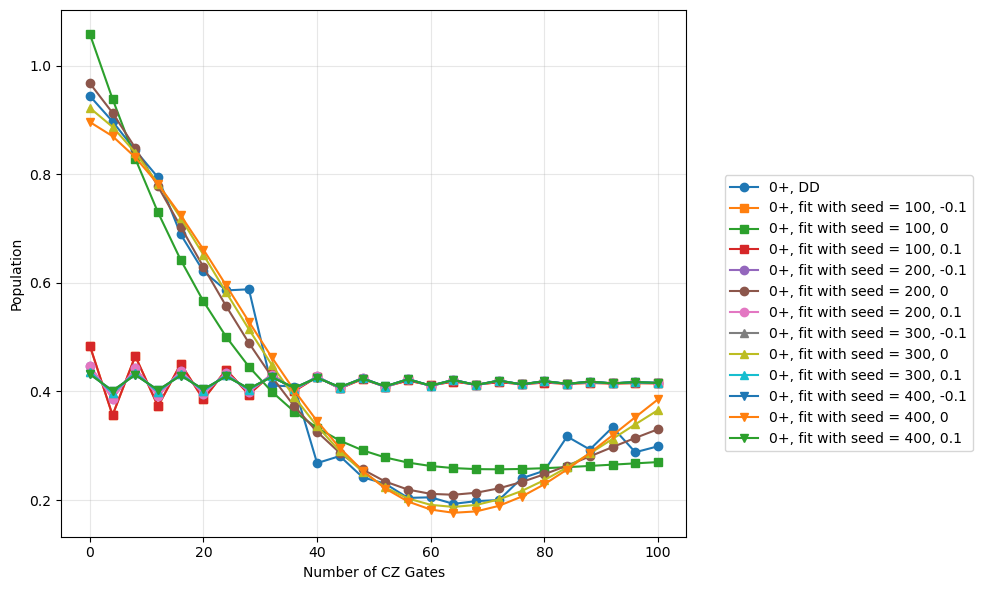

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_0P,:], marker='o', label='0+, DD')

marker = ['s', 'o', '^', 'v'];

for idx, time_seed in enumerate([100, 200, 300, 400]):
    for rotation_seed in [-0.1, 0, 0.1]:
        initial_guess = (time_seed, rotation_seed, 1, 1);
        optim_params_minimize, y, result, func = find_best_fit(
            "0+", n_cz, pop_00[Exp.DD_0P, :], device, initial_guess, opt = "minimize")
        optim_y = func(n_cz, *optim_params_minimize);
        error = np.sum(np.abs(optim_y - pop_00[Exp.DD_0P, :]) ** 2);

        print(f"Error with initial T_D = {time_seed}, rotation = {rotation_seed}: {error}")
        print(f"Params: {optim_params_minimize[0], optim_params_minimize[1]}")
        print()
        plt.plot(n_cz, func(n_cz, *optim_params_minimize), marker=marker[idx],
            label=f'0+, fit with seed = {time_seed}, {rotation_seed}')

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

For |0+> then, the RMSE depends on a lot on the angle and not on the decay timescale. The initialization as well plays a major role in whether we are able to converge to the right angle.

Check results for the |++> state

In [60]:
angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000);
spam_bound = (0, 1);

device = DeviceCharacteristics({
    "T1_1": timescale_bound, "T1_2": timescale_bound, "T2_1": timescale_bound, "T2_2": timescale_bound,
    # "T1_1": T1_1/(tg_cz+tg_X), "T1_2": T1_2/(tg_cz+tg_X), "T2_1": T2_1/(tg_cz+tg_X), "T2_2": T2_2/(tg_cz+tg_X),
    "ZZ": angle_bound, "ZI": -np.pi/4, "IZ": -np.pi/4,
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});
initial_guess = (230, 230, 230, 230, 0.01, 4/16, 1/16);

optim_params_global, y, result, func = find_best_fit("++", n_cz, pop_00[Exp.DD_PP, :], device, initial_guess, opt = "global")
optim_y = func(n_cz, *optim_params_global);
print("\nError from `global`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_global[4])

optim_params_minimize, y, result, func = find_best_fit("++", n_cz, pop_00[Exp.DD_PP, :], device, initial_guess, opt = "minimize")
optim_y = func(n_cz, *optim_params_minimize);
print("\nError from `minimize`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_minimize[4])

optim_params_curve, y, result, func = find_best_fit("++", n_cz, pop_00[Exp.DD_PP, :], device, initial_guess, opt = "curve")
optim_y = func(n_cz, *optim_params_curve);
print("\nError from `curve`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_curve[4])

optim_params_squares, y, result, func = find_best_fit("++", n_cz, pop_00[Exp.DD_PP, :], device, initial_guess, opt = "least_squares")
optim_y = func(n_cz, *optim_params_squares);
print("\nError from `least_squares`:", np.sum(np.abs(optim_y - pop_00[Exp.DD_PP, :]) ** 2))
print("Overrotation", optim_params_squares[4])


Error from `global`: 0.3551813738648343
Overrotation -0.09186534012581282

Error from `minimize`: 0.5827713689186528
Overrotation 0.021844209171468672

Error from `curve`: 0.3546433891370167
Overrotation 0.091865957991755

Error from `least_squares`: 0.3546433891370167
Overrotation 0.091865957991755


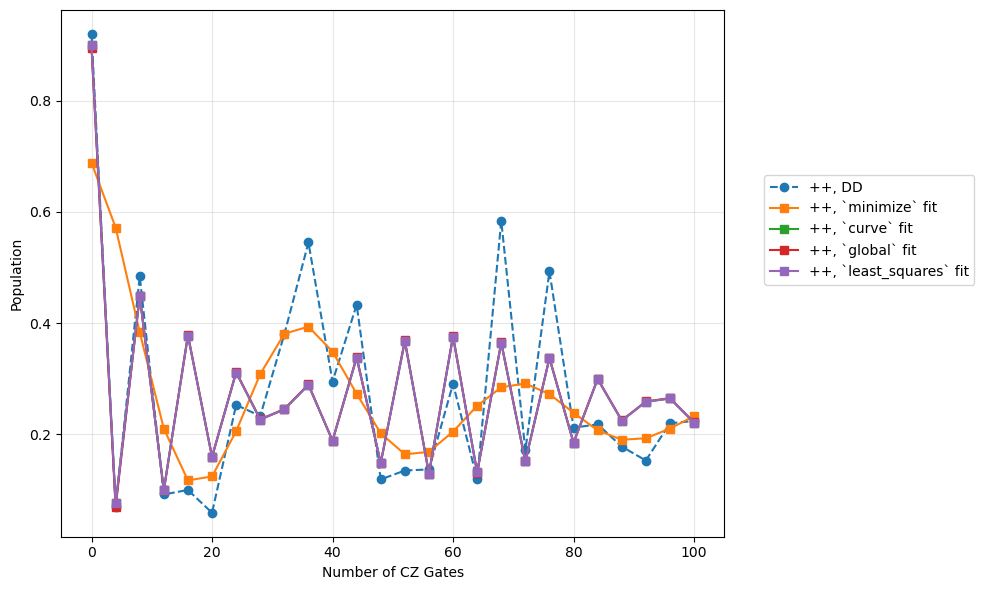

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(n_cz, pop_00[Exp.DD_PP,:], marker='o', label='++, DD', linestyle='--')
plt.plot(n_cz, func(n_cz, *optim_params_minimize), marker='s', label='++, `minimize` fit')
if optim_params_curve is not None:
    plt.plot(n_cz, func(n_cz, *optim_params_curve), marker='s', label='++, `curve` fit')
plt.plot(n_cz, func(n_cz, *optim_params_global), marker='s', label='++, `global` fit')
plt.plot(n_cz, func(n_cz, *optim_params_squares), marker='s', label='++, `least_squares` fit')
plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')
# plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()


# MIT Results

In [62]:
import numpy as np

folder = "Deterministic benchmarking result - modified"
n_cz = np.load(f"{folder}/num_cz_gates.npy");
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy");
pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 4; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

In [70]:
########
##  0+
########
exp, exp_literal = Exp.DD_0P, "0+";
device = DeviceCharacteristics({
    "T1_1": -np.inf, "T1_2": -np.inf, "T2_1": -np.inf, "T2_2": timescale_bound,
    "ZZ": -np.pi/4, "ZI": -np.pi/4, "IZ": angle_bound,
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});
initial_guess = (230, -0.1, 1, 1);
optim_params_0P, _, _, func_0P = find_best_fit(exp_literal, n_cz, pop_00[exp, :], device, initial_guess, opt = "global")

print("From 0+ experiment: ")
optim_y = func_0P(n_cz, *optim_params_0P);
print("Error:", np.sum(np.abs(optim_y - pop_00[exp, :]) ** 2))
print("Timescale", optim_params_0P[0])
print("Overrotation", optim_params_0P[1])
print()

########
##  +0
########
exp, exp_literal = Exp.DD_P0, "+0";
device = DeviceCharacteristics({
    "T1_1": -np.inf, "T1_2": -np.inf, "T2_1": timescale_bound, "T2_2": np.inf,
    "ZZ": -np.pi/4, "ZI": angle_bound, "IZ": -np.pi/4,
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});
initial_guess = (230, -0.1, 1, 1);
optim_params_P0, _, _, func_P0 = find_best_fit(exp_literal, n_cz, pop_00[exp, :], device, initial_guess, opt = "global")

print("From +0 experiment: ")
optim_y = func_P0(n_cz, *optim_params_P0);
print("Error:", np.sum(np.abs(optim_y - pop_00[exp, :]) ** 2))
print("Timescale", optim_params_P0[0])
print("Overrotation", optim_params_P0[1])
print()

########
##  ++
########
exp, exp_literal = Exp.DD_PP, "++";
device = DeviceCharacteristics({
    "T1_1": timescale_bound, "T1_2": timescale_bound, "T2_1": timescale_bound, "T2_2": timescale_bound,
    "ZZ": angle_bound, "ZI": -np.pi/4, "IZ": -np.pi/4,
    "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});
initial_guess = (230, 230, 230, 230, -0.01, 1, 1);
optim_params_PP, _, _, func_PP = find_best_fit(exp_literal, n_cz, pop_00[exp, :], device, initial_guess, opt = "global")

print("From +0 experiment: ")
optim_y = func_PP(n_cz, *optim_params_PP);
print("Error:", np.sum(np.abs(optim_y - pop_00[exp, :]) ** 2))
print("Timescale", optim_params_PP[:4])
print("Overrotation", optim_params_PP[4])

From 0+ experiment: 
Error: 0.02265236474118858
Timescale 231.66753310400503
Overrotation -0.005456554856428984

From +0 experiment: 
Error: 0.01557527052087169
Timescale 181.88623435405668
Overrotation -0.005267484231886741

From +0 experiment: 
Error: 0.35614708519040483
Timescale [957.37204602 510.14828783 825.72117759  10.90751587]
Overrotation 0.09186319223695669


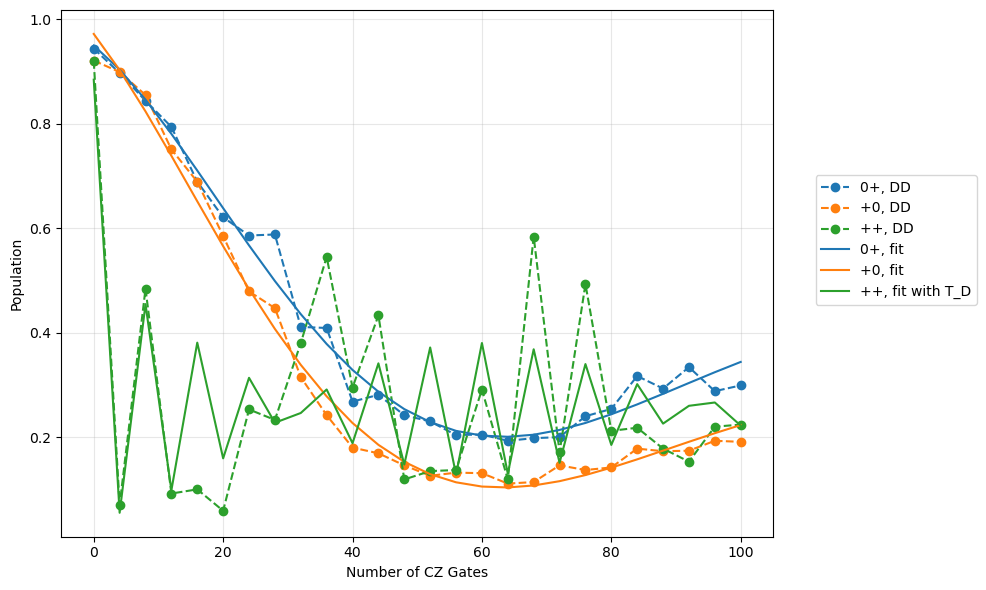

In [73]:
plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Data curves
plt.plot(n_cz, pop_00[Exp.DD_0P,:], label='0+, DD', linestyle="--", marker='o', color=colors[0])
plt.plot(n_cz, pop_00[Exp.DD_P0,:], label='+0, DD', linestyle="--", marker='o', color=colors[1])
plt.plot(n_cz, pop_00[Exp.DD_PP,:], label='++, DD', linestyle="--", marker='o', color=colors[2])

# Fit curves (use the same color as the corresponding data curve)
t = n_cz;#np.linspace(0, n_cz[-1], int(n_cz[-1]))
plt.plot(t, func_0P(t, *optim_params_0P), label='0+, fit', color=colors[0])
plt.plot(t, func_P0(t, *optim_params_P0), label='+0, fit', color=colors[1])
plt.plot(t, func_PP(t, *optim_params_PP), label='++, fit with T_D', color=colors[2])

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

# IBM results

## Extract raw data

In [74]:
measurement_points=np.arange(0,102,4)
state_list=['00','01','0+','+0','++']
qubit_list=[
    [21,22],
]
UR_list=['None','Both','0','1']
experiment_date = '06-01-25-CZ'

In [75]:
import json

circuit_list={}
for ur in UR_list:
    ur_key=f'{ur}'
    # …later, load it back
    with open(f'fitting-saurav/circuit_list_{ur_key}_{experiment_date}.json', 'r') as f:
        circuit_list[ur_key] = json.load(f)

In [76]:
import os

# Example inputs; these should already be defined in your context:
# UR_list = [...]
# circuit_list = { ur_key: [exp1, exp2, ...], ... }
# experiment_date = "2025-06-20"  # for example, or however you define it
base_dir = os.getcwd()
add_dir = "fitting-saurav"
res_dic = {}

for ur_key in UR_list:
    # Construct the directory where results were saved for this UR
    dir_path = os.path.join(base_dir, add_dir, experiment_date, ur_key)
    if not os.path.isdir(dir_path):
        # Handle missing directory as appropriate: you may skip or raise an error.
        raise FileNotFoundError(f"Expected directory not found: {dir_path}")
    
    # For possible per-UR grouping if desired
    res_dic_save = {}
    
    for exp in circuit_list.get(ur_key, []):
        filename = f"results-{exp}.json"
        file_path = os.path.join(dir_path, filename)
        
        if not os.path.isfile(file_path):
            # Handle missing file: skip, warn, or raise
            raise FileNotFoundError(f"Expected file not found: {file_path}")
        
        with open(file_path, "r") as f:
            counts = json.load(f)
        
        # Store in the per-UR dictionary
        res_dic_save[exp] = counts
        
        # Store in the global flat dictionary, matching your saving key
        res_dic[f"{ur_key}-{exp}"] = counts
    
    # If you wish to keep a mapping per UR, you can store res_dic_save:
    # per_UR_results[ur_key] = res_dic_save
    # (Define per_UR_results = {} before the loop if needed.)

In [77]:
import math

def fid_CT(counts_in):
    """
    From a dict of 2-bit measurement counts, compute:
      - counts_00: raw shots where the outcome is '00'
      - p_00:      probability of '00'
      - sigma_00:  binomial std. deviation of p_00
    Returns (p_00, sigma_00, counts_00).
    """
    total_counts = sum(counts_in.values())
    if total_counts == 0:
        raise ValueError("No counts provided (sum is zero).")

    # Raw count for exactly '00'
    counts_00 = counts_in.get('00', 0)

    # Probability and its binomial σ
    p_00 = counts_00 / total_counts
    sigma_00 = math.sqrt(p_00 * (1 - p_00) / total_counts)

    return p_00, sigma_00


In [78]:
# assume fid_CT and fid_GHZ are already defined, and res_dic is your input dict

fid = {}
err = {}

for key, counts in res_dic.items():
        p, sigma = fid_CT(counts)
        fid[key] = p
        err[key] = sigma

# now fid and err hold your probabilities and uncertainties, e.g.
print(fid)
print(err)


{'None-00-0': 0.997, 'None-01-0': 0.9975, 'None-0+-0': 0.997, 'None-+0-0': 0.993, 'None-++-0': 0.994, 'None-00-4': 0.998, 'None-01-4': 0.995, 'None-0+-4': 0.978, 'None-+0-4': 0.946, 'None-++-4': 0.9395, 'None-00-8': 0.9975, 'None-01-8': 0.9855, 'None-0+-8': 0.959, 'None-+0-8': 0.8865, 'None-++-8': 0.886, 'None-00-12': 0.9985, 'None-01-12': 0.986, 'None-0+-12': 0.9445, 'None-+0-12': 0.79, 'None-++-12': 0.791, 'None-00-16': 0.999, 'None-01-16': 0.985, 'None-0+-16': 0.949, 'None-+0-16': 0.6765, 'None-++-16': 0.7275, 'None-00-20': 0.9965, 'None-01-20': 0.982, 'None-0+-20': 0.9305, 'None-+0-20': 0.5685, 'None-++-20': 0.6405, 'None-00-24': 0.9965, 'None-01-24': 0.976, 'None-0+-24': 0.902, 'None-+0-24': 0.4395, 'None-++-24': 0.5505, 'None-00-28': 0.9985, 'None-01-28': 0.9715, 'None-0+-28': 0.8935, 'None-+0-28': 0.3385, 'None-++-28': 0.4565, 'None-00-32': 0.999, 'None-01-32': 0.9685, 'None-0+-32': 0.888, 'None-+0-32': 0.213, 'None-++-32': 0.36, 'None-00-36': 0.9965, 'None-01-36': 0.9655, 'None

## Extracting fit parameters

In [94]:
def init_device_characteristics():
    return DeviceCharacteristics({
            "T1_1": timescale_bound, "T1_2": timescale_bound, "T2_1": timescale_bound, "T2_2": timescale_bound,
            "ZZ": angle_bound, "ZI": angle_bound, "IZ": angle_bound,
            "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});

In [108]:
# Matplotlib global settings
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Apple LiSung'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{braket}'

# Font settings for titles and axis labels
font_properties = {
    'fontsize': 18,
    'fontname': 'Times New Roman'
}
    
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'x', '+']

for ur in UR_list:
    fig, ax = plt.subplots(figsize=(8, 5))
    for st_ix, state in enumerate(state_list):
        # Prepare data arrays
        t_data = np.array(measurement_points, dtype=float)
        y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
        y_err  = np.array([err[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)

        device = init_device_characteristics();
        match state:
            case "00":
                device.update_dict({"T1_1": np.inf, "T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf})
                continue
            case "01":
                device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T2_2": np.inf})
                continue
            case "10":
                device.update_dict({"T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf})
                continue
            case "0+":
                device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T1_2": np.inf})
            case "+0":
                device.update_dict({"T1_1": np.inf, "T1_2": np.inf, "T2_2": np.inf})
            case "++":
                pass
        match ur:
            case 'None':
                pass
            case 'Both':
                device.update_dict({"ZI": -np.pi/4, "IZ": -np.pi/4})
            case '0':
                device.update_dict({"ZZ": -np.pi/4, "ZI": -np.pi/4})
            case '1':
                device.update_dict({"ZI": -np.pi/4, "ZZ": -np.pi/4})
        keys = device.get_optimizee_keys()
        initial_guess = []
        for key in keys:
            if key.startswith("T"):
                # Decay timescale params
                initial_guess.append(230)
            elif key.endswith("spam"):
                # SPAM params
                initial_guess.append(1)
            else:
                # Angle params
                initial_guess.append(-0.01)

        exp_literal = state;
        optim_params, _, _, func = find_best_fit(exp_literal, t_data, y_data, device, initial_guess, opt = "global")
        print(f'{ur}-{state} experiment: {keys} -> {optim_params}')
        
        # Plot the raw data points (errorbars) without connecting lines
        eb = ax.errorbar(
            t_data,
            y_data,
            yerr=y_err,
            marker=markers[st_ix],
            linestyle='None',        # no line between points
            label=f'$|{state}\\rangle$',
            capsize=3,
        )
        # Extract the color that matplotlib chose for this dataset:
        # Errorbar returns an ErrorbarContainer; its `.lines` attribute 
        # (in recent matplotlib versions) gives a list whose first element is the Line2D for the data points.
        try:
            color = eb.lines[0].get_color()
        except Exception:
            # Fallback: let matplotlib cycle the same color for the fit automatically
            color = None
        # Plot the fitted curve with same color, semi-transparent
        ax.plot(
            t_data,
            func(t_data, *optim_params),
            linestyle='-',
            color=color,
            alpha=0.5,
            label=None  # do not add extra legend entry for each fit; if desired, adjust
        )

    ax.set_xlabel(r'$\#\ \text{of CZ}$', fontdict=font_properties)
    ax.set_ylabel('Fidelity',             fontdict=font_properties)
    ax.tick_params(axis='both', labelsize=18)
    
    # Legend: 3 columns, centered above the plot
    legend = ax.legend(
        ncol=5,
        fontsize=14,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),      # just above the top of the axes
        frameon=False
    )
    
    # Figure title (on top of legend)
    fig.suptitle(
        f'X: {ur}',
        fontdict=font_properties,
        y=.85               # push it above the legend
    )
    
    # Make room for title + legend and tighten up the rest
    fig.tight_layout(rect=[0, 0, 1, 0.3])
    
    # Save and close
    filename = f"{experiment_date}_{ur.replace('/', '_')}-fit.pdf"
    fig.savefig(filename, dpi=300)
    plt.close(fig)
    
    print(f"Saved {filename}")


None-0+ experiment: ['T2_2', 'ZZ', 'ZI', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 7.79807449e+02  6.02002909e-02 -3.18750883e-02 -5.96740294e-02
  3.25221760e-01  6.67079062e-01]
None-+0 experiment: ['T2_1', 'ZZ', 'ZI', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 9.98162133e+02  1.81031101e-02 -2.63533983e-02  9.83570237e-02
  4.73852367e-01  5.24077279e-01]
None-++ experiment: ['T1_1', 'T1_2', 'T2_1', 'T2_2', 'ZZ', 'ZI', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 2.18371403e+02  4.74237499e+02  9.66001781e+02  7.63030141e+02
 -1.86329853e-03 -6.26483187e-03 -1.15039630e-04  2.36936841e-01
  6.22855148e-02]
Saved 06-01-25-CZ_None-fit.pdf
Both-0+ experiment: ['T2_2', 'ZZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 2.38233776e+02 -1.76093451e-07  6.97877705e-01  2.90776589e-01]


/var/folders/ng/dq6bzyqx5tj5x__xgyf7x4t80000gn/T/ipykernel_60005/2458307485.py:114: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 1, 0.3])


Both-+0 experiment: ['T2_1', 'ZZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 6.28091917e+02 -1.16546489e-04  5.73503100e-01  4.11860245e-01]
Both-++ experiment: ['T1_1', 'T1_2', 'T2_1', 'T2_2', 'ZZ', 'infinite_time_spam', 'zero_time_spam'] -> [8.93277071e+02 4.91084520e+01 6.92240047e+02 8.04340732e+02
 1.18414832e-03 6.24782813e-01 3.08319646e-02]
Saved 06-01-25-CZ_Both-fit.pdf
0-0+ experiment: ['T2_2', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 5.34664016e+02 -8.93099107e-04  1.96870553e-01  7.85737386e-01]
0-+0 experiment: ['T2_1', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [7.72985675e+02 2.76792207e-02 7.98887757e-01 1.89679662e-01]
0-++ experiment: ['T1_1', 'T1_2', 'T2_1', 'T2_2', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [ 3.96833209e+02  4.89043824e+02  2.24935335e+02  6.85675866e+02
 -2.71887803e-03  5.33400620e-01  5.75056292e-02]
Saved 06-01-25-CZ_0-fit.pdf
1-0+ experiment: ['T2_2', 'IZ', 'infinite_time_spam', 'zero_time_spam'] -> [2.15601338e+02 7.95

In [82]:
x = [123]
x.append(12)
print(x)

[123, 12]


In [200]:
T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 50; # microseconds

tg_X = 0.036; # microseconds
tg_cz = 0.068; # microseconds

In [204]:
t_data = np.array(measurement_points, dtype=float)


ur, state = '1', '+0'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_P0 = extract_params(Exp.DD_P0, t_data, y_data);

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_PP = extract_params(Exp.DD_PP, t_data, y_data);

print("From 0+ experiment: ")
print(fit_params_0P["extracted_params"])
print()

print("From +0 experiment: ")
print(fit_params_P0["extracted_params"])
print()

print("From ++ experiment: ")
print(fit_params_PP["extracted_params"])

From 0+ experiment: 
{'IZ': np.float64(0.0005485490609002152), 'T_D': np.float64(638.021261516729), 'spam': array([0.00146656, 0.98330814])}

From +0 experiment: 
{'ZI': np.float64(-0.0018108737036094287), 'T_D': np.float64(472.15170663893804), 'spam': array([0.40863639, 0.58207751])}

From ++ experiment: 
{'ZZ': np.float64(-0.0010805290486578967), 'spam': array([0.61178054, 0.03196973]), 'T1_1': np.float64(51.68625704669373), 'T1_2': np.float64(989.6081829885372), 'T2_1': np.float64(957.5775386461322), 'T2_2': np.float64(617.1549283121135)}


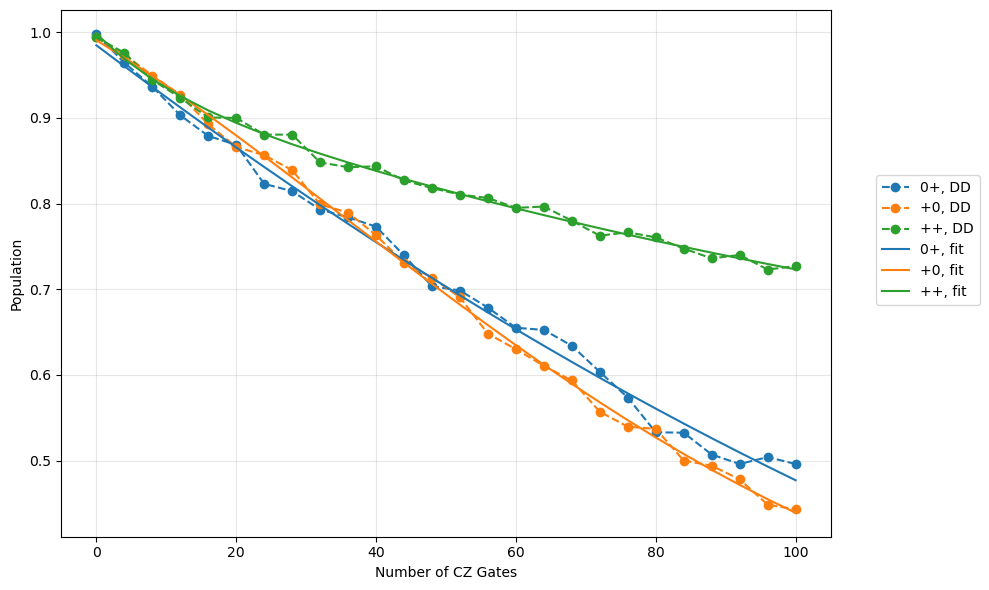

In [205]:
plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Data curves
ur, state = '0', '0+'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='0+, DD', linestyle="--", marker='o', color=colors[0])

ur, state = '1', '+0'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='+0, DD', linestyle="--", marker='o', color=colors[1])

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
plt.plot(t_data, y_data, label='++, DD', linestyle="--", marker='o', color=colors[2])

# Fit curves (use the same color as the corresponding data curve)
t = t_data; #np.linspace(0, t_data[-1], int(t_data[-1]))
plt.plot(t, fit_curve_for_DD_0P(t, *fit_params_0P["plotting_params"]), label='0+, fit', color=colors[0])
plt.plot(t, fit_curve_for_DD_P0(t, *fit_params_P0["plotting_params"]), label='+0, fit', color=colors[1])
plt.plot(t, fit_curve_for_DD_PP(t, *fit_params_PP["plotting_params"]), label='++, fit', color=colors[2])

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()

In [213]:
print(UR_list)

['None', 'Both', '0', '1']


In [ ]:
t_data = np.array(measurement_points, dtype=float)

for ur in UR_list:
    for state in state_list:
        y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
        if state in ['0+', '+0']:
            fit_params = extract_params(Exp.DD_P0, t_data, y_data);
            plt.plot()
        elif state in ['++']:
            if ur == 'None':
                fit_params = extract_params(Exp.PP, t_data, y_data);
            if ur == 'None':
                fit_params = extract_params(Exp.PP, t_data, y_data);
        print(fit_params_0P)

ur, state = '1', '+0'

ur, state = 'Both', '++'
y_data = np.array([fid[f'{ur}-{state}-{mp}'] for mp in measurement_points], dtype=float)
fit_params_PP = extract_params(Exp.DD_PP, t_data, y_data);

print("From 0+ experiment: ")
print(fit_params_0P["extracted_params"])
print()

print("From +0 experiment: ")
print(fit_params_P0["extracted_params"])
print()

print("From ++ experiment: ")
print(fit_params_PP["extracted_params"])